In [142]:
import pandas as pd

In [143]:
train = pd.read_csv('../input/train.csv')
holdout = pd.read_csv('../input/test.csv')

In [144]:
def process_age(df):
    df['Age'] = df['Age'].fillna(-0.5)
    cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
    label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels=label_names)
    return df

In [145]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

In [146]:
train = process_age(train)
holdout = process_age(holdout)

In [147]:
column = ['Age_categories', 'Pclass', 'Sex']
for c in column:
    train = create_dummies(train, c)
    holdout = create_dummies(holdout, c)
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


In [148]:
columns = ['SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
train[columns].describe(include='all')

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.000000,NaN,NaN


In [149]:
from sklearn.preprocessing import minmax_scale

In [150]:
train.Embarked = train.Embarked.fillna('S')
holdout.Embarked = holdout.Embarked.fillna('S')

In [151]:
train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

In [152]:
holdout[columns].describe(include='all')

,SibSp,Parch,Fare,Cabin,Embarked
count,418.000000,418.000000,417.000000,91,418
unique,NaN,NaN,NaN,76,3
top,NaN,NaN,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,NaN,3,270
mean,0.447368,0.392344,35.627188,NaN,NaN
std,0.896760,0.981429,55.907576,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.895800,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.500000,NaN,NaN


In [153]:
holdout.Fare = holdout.Fare.fillna(train.Fare.mean())

In [154]:
train['SibSp_scaled'] = minmax_scale(train.SibSp)
train['Parch_scaled'] = minmax_scale(train.Parch)
train['Fare_scaled'] = minmax_scale(train.Fare)

holdout['SibSp_scaled'] = minmax_scale(holdout.SibSp)
holdout['Parch_scaled'] = minmax_scale(holdout.Parch)
holdout['Fare_scaled'] = minmax_scale(holdout.Fare)

/Users/wyj/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [155]:
from sklearn.linear_model import LogisticRegression

In [156]:
lr = LogisticRegression()
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']
train_X = train[columns]
train_y = train.Survived
lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [157]:
coefficients = lr.coef_
print(coefficients)

[[-0.34723567  1.86060592  0.34493188 -0.18273418 -0.0110893  -0.52620202
  -0.90049959  1.04515623  0.13729476 -0.94467395  1.45610934 -1.2183323
   0.25010253  0.24374319 -0.25606868 -1.74775712 -0.77650208  0.54308487]]


In [158]:
feature_importance = pd.Series(coefficients[0], index=train_X.columns)

In [159]:
import matplotlib.pyplot as plt

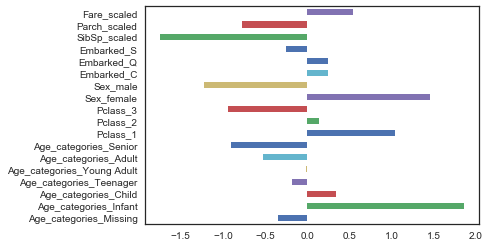

In [160]:
feature_importance.plot.barh()
plt.show()

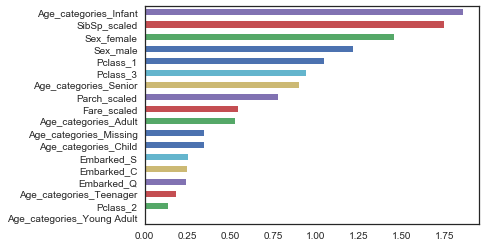

In [161]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [162]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled'] # top 8

In [163]:
# 交叉验证测试模型效果
lr = LogisticRegression()
from sklearn.model_selection import cross_val_score
train_X = train[columns]
train_Y = train.Survived
scores = cross_val_score(lr, train_X, train_Y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148019521053229


In [164]:
lr = LogisticRegression()
all_X = train[columns]
all_y = train.Survived
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

In [165]:
def process_fare(df, cut_points, label_names):
    df['Fare_categories'] = pd.cut(df['Fare'], cut_points, labels=label_names)
    return df

In [166]:
train = process_fare(train, [0, 12, 50, 100, 1000], ['0-12', '12-50', '50-100', '100+'])
holdout = process_fare(holdout, [0, 12, 50, 100, 1000], ['0-12', '12-50', '50-100', '100+'])

train = create_dummies(train, 'Fare_categories')
holdout = create_dummies(holdout, 'Fare_categories')

In [167]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
title = holdout.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
holdout['Title'] = title.map(titles)

In [168]:
train['Cabin_type'] = train.Cabin.str[0]
holdout['Cabin_type'] = holdout.Cabin.str[0]

In [169]:
train.Cabin_type = train.Cabin_type.fillna('Unknown')
holdout.Cabin_type = holdout.Cabin_type.fillna('Unknown')

In [170]:
col = ['Title', 'Cabin_type']
for c in col:
    train = create_dummies(train, c)
    holdout = create_dummies(holdout, c)

In [171]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

In [172]:
import seaborn as sns
import numpy as np

In [173]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

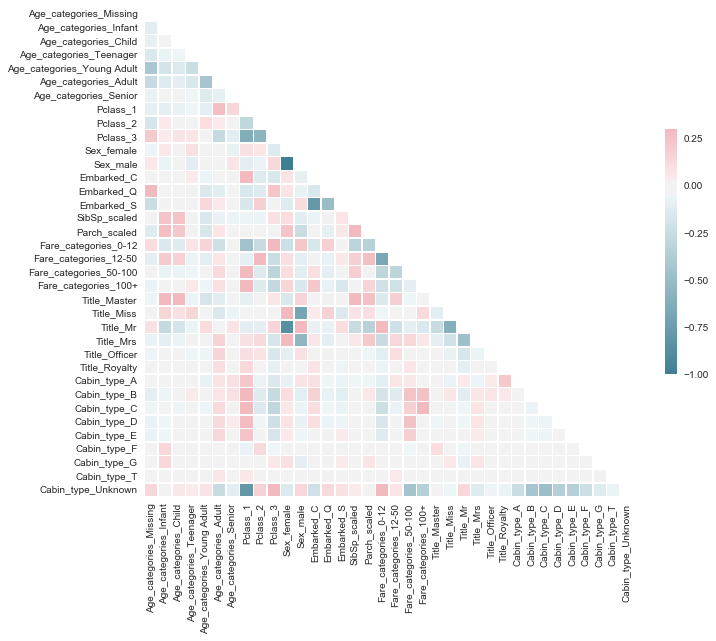

In [174]:
plot_correlation_heatmap(train[columns])

In [175]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

In [176]:
lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimized_columns = all_X.columns[selector.support_]

In [177]:
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

In [178]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
accuracy = cross_val_score(lr, all_X, all_y, cv=10).mean()
print(accuracy)

0.8226549199863807


In [188]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

In [189]:
holdout_predictions.sum()

168

In [190]:
submission = pd.DataFrame({'PassengerID':holdout.PassengerId, 'Survived':holdout_predictions})

In [191]:
submission.to_csv('submission_1.csv', index=False)

In [183]:
sub1 = pd.read_csv('submission_1.csv')
sub2 = pd.read_csv('submission_2.csv')

In [184]:
sub1.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [185]:
sub2.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [186]:
sub1.describe()

,PassengerID,Survived
count,418.000000,418.000000
mean,1100.500000,0.401914
std,120.810458,0.490872
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [187]:
sub2.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.394737
std,120.810458,0.489380
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000
